In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
base_data_dir = './data'

In [3]:
latest_data_dir_num = max([int(dir.split('_')[-1]) for dir in os.listdir(base_data_dir) if dir.split('_')[-1].isdigit()])
data_dir = [dir for dir in os.listdir(base_data_dir) if dir.split('_')[-1].isdigit() and int(dir.split('_')[-1]) == latest_data_dir_num][0]
data_dir = f'{base_data_dir}/{data_dir}'

In [4]:
data_dir

'./data/decoded_data_41'

In [5]:
import h5py

In [6]:
with h5py.File(f'{data_dir}/images.h5') as f:
    images = f['images'][:].squeeze()

with h5py.File(f'{data_dir}/labels.h5') as f:
    labels = f['labels'][:]

# loading the training and validation arrays
# with h5py.File(f'{data_dir}/train_images.h5') as f:
#     train_images = f['images'][:].squeeze()

# with h5py.File(f'{data_dir}/train_labels.h5') as f:
#     train_labels = f['labels'][:]

# with h5py.File(f'{data_dir}/val_images.h5') as f:
#     val_images = f['images'][:].squeeze()

# with h5py.File(f'{data_dir}/val_labels.h5') as f:
#     val_labels = f['labels'][:]

In [7]:
def transform_image(image, threshold=None, return_inverse=False):
    fft_image = np.fft.fft2(image)
    if threshold is None:
        threshold = 0.0000005 * np.abs(fft_image)
    # creating a mask for zeroing low amplitudes, i.e: below the threshold
    mask = np.ones_like(fft_image)
    mask[np.abs(fft_image) <= threshold] = 0
    filtered_fft_image = fft_image * mask
    # getting the inverse fourier transform on the filtered image
    inverse_fft_image = np.fft.ifft2(filtered_fft_image)
    transformed_image = np.real(inverse_fft_image * np.conj(inverse_fft_image))
    # normalizing to [0, 255] range
    transformed_image = transformed_image / transformed_image.max()
    transformed_image *= 255
    if return_inverse:
        return fft_image, transformed_image
    return transformed_image

def filter(inverse):
    ones = np.ones_like(inverse)
    epsilon = 0.000001
    border = 0
    center_y, center_x = ones.shape[0]//2, ones.shape[1]//2
    center = np.array([center_y, center_x])

    ones[center_y-border:center_y+border+1, center_x-border:center_x+border+1] = 0 + epsilon
    v, u = np.mgrid[:inverse.shape[0], :inverse.shape[1]]

    distances_from_center = np.sqrt(
        np.square(v - center[0]) + np.square(u - center[1])
    )
    threshold = 40
    mask = distances_from_center <= threshold

    return inverse * mask

## Fine tuning the autoencoder model

In [8]:
import torch
import torch.nn as nn

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
import modules.models
from modules.models.models import ConvClassifier
from modules.models.dataset import AlzheimerDataset

In [11]:
import modules.db
from modules.db.optuna_report import report_optuna_trial, report_study_best_loss_value, get_best_hyperparameters

In [12]:
alzheimer_dataset = AlzheimerDataset(images, labels)
# train_dataset = AlzheimerDataset(train_images, train_labels)
# val_dataset = AlzheimerDataset(val_images, val_labels)

In [13]:
(encoded_dim, 
    initial_out_channels,
    learning_rate,
    weight_decay,
    betas,
    momentum,
    dampening,
    optimizer_idx,
    scheduler_gamma,
    kl_divergence_lambda,
    epochs,
    batch_size,
    relu_slope) = get_best_hyperparameters(from_last_study=True) # get hyperparameters from the study, if studied

train_best_params = {
    'encoded_dim': encoded_dim,
    'initial_out_channels': initial_out_channels,
    'lr': learning_rate,
    'weight_decay': weight_decay,
    'betas': betas,
    'momentum': momentum,
    'dampening': dampening,
    'optimizer_idx': optimizer_idx,
    'scheduler_gamma': scheduler_gamma,
    'kl_divergence_lambda': kl_divergence_lambda,
    'epochs': epochs,
    'batch_size': batch_size,
    'loss_idx': 0,
    'relu_slope': relu_slope
}

In [14]:
def train_epoch(model, optimizer, loss, dataloader, val_dataset, overall_losses, val_overall_losses, accuracy, val_accuracy, epoch, scheduler=None, writer=None):
    for _, (batch_X, batch_y) in enumerate(dataloader):
        batch_X = batch_X.to(device=model.device)
        batch_y = batch_y.to(device=model.device)

        if batch_X.shape[0] == 1:
            batch_X = torch.concat((batch_X, batch_X), dim=0).to(device=model.device)
            batch_y = torch.concat((batch_y, batch_y), dim=0).to(device=model.device)
        
        optimizer.zero_grad()
        
        batch_output = model(batch_X)
        batch_loss = loss(batch_output, batch_y)
        overall_losses[epoch] += batch_loss.item()

        predictions = torch.argmax(batch_output, dim=1).to(model.device)
        accuracy[epoch] += (predictions == batch_y).sum().item()
    
        batch_loss.backward()
        optimizer.step()
    
    # updating train metrics
    overall_losses[epoch] /= dataloader.dataset.y.shape[0]
    accuracy[epoch] /= dataloader.dataset.y.shape[0]

    if writer:
        writer.add_scalar('Overall Loss/Train', overall_losses[epoch], epoch)
        writer.add_scalar('Accuracy/Train', accuracy[epoch], epoch)
        
    # validation
    with torch.no_grad():
        model.eval()
        val_output = model(val_dataset.X.to(model.device))
        loss_value = loss(val_output, val_dataset.y.to(model.device))

        val_overall_losses[epoch] = loss_value.item() / val_dataset.y.shape[0]

        predictions = torch.argmax(val_output, dim=1).to(model.device)
        val_accuracy[epoch] = (predictions == val_dataset.y.to(model.device)).sum().item() / predictions.shape[0]

        if writer:
            writer.add_scalar('Overall Loss/Validation', val_overall_losses[epoch], epoch)
            writer.add_scalar('Accuracy/Validation', val_accuracy[epoch], epoch)

    # update learning rate after each epoch to have equal effect for every batch
    if scheduler is not None:
        scheduler.step()
    

In [15]:
from tqdm.notebook import tqdm

In [16]:
import modules.db
from modules.db.optuna_report import report_optuna_trial, report_study_best_loss_value

In [17]:
from torch.utils.tensorboard import SummaryWriter
import optuna

In [18]:
classification_studies_dir = './data/studies/classification'
if not os.path.isdir(classification_studies_dir):
    os.mkdir(classification_studies_dir)
studies_directories = os.listdir(classification_studies_dir)
# if last study wasn't finished, use that study id in tensorboard and later on in resuming the optuna study
if len(studies_directories) > 0:
    current_study_id = studies_directories[-1].split('-')[-1]
# last study finished successfully so we'll start a brand new one
# else:
#     current_study_id = get_last_study_id() + 1
# current_study_id

In [42]:
# if trial is None we're going for multi-objective optimization or we're normally training
def train(trial, model, optimizer, loss, epochs, dataloader, val_dataset, scheduler=None, plot=True, show_progress=True):
    log_dir = f'./logs/classification/study-{0}/trial-{trial.number}' if trial else f'./logs/classiciation/regular/'
    writer = SummaryWriter(log_dir=log_dir)

    writer.add_graph(model, next(iter(dataloader))[0].to(device=model.device))
    
    overall_losses, val_overall_losses = torch.zeros(epochs), torch.zeros(epochs)
    accuracy, val_accuracy = torch.zeros(epochs), torch.zeros(epochs)
    
    # using tqdm has conflicts with optuna's study progress bar
    epochs_range = tqdm(range(epochs)) if show_progress else range(epochs)
    for epoch in epochs_range:
        model.train()
        
        train_epoch(
            model=model,
            optimizer=optimizer, 
            loss=loss,
            epoch=epoch,
            dataloader=dataloader,
            val_dataset=val_dataset,
            val_overall_losses=val_overall_losses,
            accuracy=accuracy,
            val_accuracy=val_accuracy,
            overall_losses=overall_losses,
            scheduler=scheduler,
            writer=writer
        )

        writer.flush()
        
        if trial is not None:
            trial.report(overall_losses[epoch].item(), epoch)

            if trial.should_prune():
                writer.close()
                raise optuna.TrialPruned()

    if plot:
        fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(16, 10))
        
        axes[0].plot(overall_losses.cpu(), color='blue', label='Train')
        axes[0].plot(val_overall_losses.cpu(), color='orange', label='Validation')
        axes[0].set_title('Overall Loss')
        axes[0].legend()

        axes[1].plot(accuracy.cpu(), color='blue', label='Train Accuracy')
        axes[1].plot(val_accuracy.cpu(), color='orange', label='Validation Accuracy')
        axes[1].set_title('Accuracy')
        axes[1].legend()

    # writer.flush()
    writer.close()
    
    return (overall_losses, val_overall_losses), (accuracy, val_accuracy)

In [20]:
def get_classification_loss_function(idx, device='cpu'):
    # getting the distribution of data
    _, counts = np.unique(labels, return_counts=True)
    counts = counts.astype(np.float32)
    counts /= counts.sum()
    # giving minority classes larger weights
    weights = 1 - torch.from_numpy(counts).to(dtype=torch.float32, device=device)
    return nn.CrossEntropyLoss(reduction='sum', weight=weights) if idx == 0 else nn.NLLLoss(reduction='sum', weight=weights)

In [21]:
def initialize_hyperparameters(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 0.1, 0.4, log=True)
    beta1 = trial.suggest_float('beta1', 0.8, 0.999)
    beta2 = trial.suggest_float('beta2', 0.5, 0.999)

    momentum = trial.suggest_float('momentum', 0, 0.5)
    dampening = trial.suggest_float('dampening', 0, 0.5)

    optimizer_idx = trial.suggest_int('optimizer_idx', 0, 1)
    # optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))

    scheduler_gamma = trial.suggest_float('scheduler_gamma', 0.8, 0.999)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)

    epochs = trial.suggest_int('epochs', 50, 128)
    batch_size = trial.suggest_int('batch_size', 33, 256)

    loss_idx = trial.suggest_int('loss_idx', 0, 1)

    relu_slope = trial.suggest_float('relu_slope', 0, 0.1)
    num_blocks = trial.suggest_int('num_blocks', 0, 5)

    # dataset_idx = trial.suggest_int('dataset_idx', 0, 2)
    # dataset = datasets[dataset_idx]

    # dataloader = torch.utils.data.DataLoader(alzheimer_dataset, batch_size=batch_size, shuffle=True)

    return lr, weight_decay, (beta1, beta2), momentum, dampening, optimizer_idx, scheduler_gamma, epochs, batch_size, loss_idx, relu_slope, num_blocks

In [22]:
def objective(trial):
    (lr,
     weight_decay,
     betas,
     momentum,
     dampening,
     optimizer_idx,
     scheduler_gamma,
     epochs,
     batch_size,
     loss_idx,
     relu_slope,
     num_blocks) = initialize_hyperparameters(trial)
    
    model = ConvClassifier(train_params=train_best_params, num_classes=len(np.unique(labels)),
                           num_blocks=num_blocks, relu_slope=relu_slope, device=device).to(device)

    if optimizer_idx == 0:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
    loss = get_classification_loss_function(loss_idx, device=model.device)

    # if train_dataset.X.shape[0] % batch_size == 1:
    #     return float('inf')
    
    dataloader = torch.utils.data.DataLoader(alzheimer_dataset, batch_size=batch_size, shuffle=True)
    
    overall, _ = train(
        model=model,
        optimizer=optimizer,
        loss=loss,
        epochs=epochs,
        dataloader=dataloader,
        val_dataset=alzheimer_dataset,
        scheduler=scheduler,
        plot=False,
        show_progress=False,
        trial=trial
    )
    
    overall_train_losses, val_overall_losses = overall
    
    # saving the best trained model exploded the VRAM so we'll have to do with the best parameters and then retrain 
    # trial.set_user_attr(key='best_booster', value=autoencoder)
    
    return val_overall_losses[-1].item() # overall_train_losses[-1].item()

In [23]:
def multi_objective(trial):
    (lr,
     weight_decay,
     betas,
     momentum,
     dampening,
     optimizer_idx,
     scheduler_gamma,
     epochs,
     batch_size,
     loss_idx,
     relu_slope,
     num_blocks) = initialize_hyperparameters(trial)
    
    model = ConvClassifier(train_params=train_best_params, num_classes=len(np.unique(labels)),
                           num_blocks=num_blocks, relu_slope=relu_slope, device=device).to(device)

    if optimizer_idx == 0:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma) if scheduler_gamma < 0.9 else None
    loss = get_classification_loss_function(loss_idx, device=model.device)

    # if train_dataset.X.shape[0] % batch_size == 1:
    #     return float('inf')
    
    dataloader = torch.utils.data.DataLoader(alzheimer_dataset, batch_size=batch_size, shuffle=True)
    
    overall, _ = train(
        model=model,
        optimizer=optimizer,
        loss=loss,
        epochs=epochs,
        dataloader=dataloader,
        val_dataset=alzheimer_dataset,
        scheduler=scheduler,
        plot=False,
        show_progress=False,
        trial=None
    )
    
    overall_train_losses, val_overall_losses = overall
    # train_accuracy, val_accuracy = accuracy
    
    # TODO: check BCE vs NLLLoss scales
    return overall_train_losses[-1].item(), val_overall_losses[-1].item()

In [24]:
import asyncio
import nest_asyncio

In [25]:
def callback(study, trial):
    report_optuna_trial(study, trial)

In [26]:
def optimize(is_multi_objective, n_trials=100):
    directions = ['minimize', 'minimize'] if is_multi_objective else ['minimize']
    objective_func = multi_objective if is_multi_objective else objective
    study = optuna.create_study(directions=directions)
    study.optimize(objective_func, n_trials=n_trials, timeout=3600*(n_trials // 30), show_progress_bar=True, gc_after_trial=True) # , callbacks=[callback])
    return study

In [27]:
is_multi_objective = False
n_trials = 50
study = optimize(is_multi_objective=is_multi_objective, n_trials=n_trials)

[I 2024-12-16 10:04:37,759] A new study created in memory with name: no-name-cde09bcb-c863-46c1-a205-c105046abe73


  0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 191 / 192 (99.5%)
Greatest absolute difference: 0.02552652359008789 at index (2, 1) (up to 1e-05 allowed)
Greatest relative difference: 0.017465865493945038 at index (2, 1) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:05:52,125] Trial 0 finished with value: 0.05814164876937866 and parameters: {'lr': 0.001211287021352115, 'weight_decay': 0.3344911970360955, 'beta1': 0.8359912550332532, 'beta2': 0.6236940569595526, 'momentum': 0.40527756753575667, 'dampening': 0.40886112013700293, 'optimizer_idx': 0, 'scheduler_gamma': 0.8816765158812544, 'epochs': 66, 'batch_size': 48, 'loss_idx': 1, 'relu_slope': 0.017009134052838527, 'num_blocks': 4}. Best is trial 0 with value: 0.05814164876937866.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 1004 / 1004 (100.0%)
Greatest absolute difference: 0.17814600467681885 at index (147, 2) (up to 1e-05 allowed)
Greatest relative difference: 0.135221874639022 at index (120, 0) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:06:36,226] Trial 1 finished with value: 0.6157715320587158 and parameters: {'lr': 5.752588452329611e-05, 'weight_decay': 0.218633986175645, 'beta1': 0.921300931335223, 'beta2': 0.510130451831242, 'momentum': 0.2642883678620352, 'dampening': 0.17673054040136088, 'optimizer_idx': 1, 'scheduler_gamma': 0.9454980179887886, 'epochs': 70, 'batch_size': 251, 'loss_idx': 0, 'relu_slope': 0.08788785866020572, 'num_blocks': 0}. Best is trial 0 with value: 0.05814164876937866.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 936 / 936 (100.0%)
Greatest absolute difference: 0.06072127819061279 at index (130, 0) (up to 1e-05 allowed)
Greatest relative difference: 0.04475340016964166 at index (130, 0) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:07:28,085] Trial 2 finished with value: 0.9070464372634888 and parameters: {'lr': 1.605631305591169e-05, 'weight_decay': 0.2425542356971112, 'beta1': 0.9293971288644326, 'beta2': 0.9292570110098592, 'momentum': 0.13049132517901402, 'dampening': 0.04882911674238399, 'optimizer_idx': 0, 'scheduler_gamma': 0.9145080650621913, 'epochs': 81, 'batch_size': 234, 'loss_idx': 0, 'relu_slope': 0.03184176618047179, 'num_blocks': 3}. Best is trial 0 with value: 0.05814164876937866.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 1019 / 1020 (99.9%)
Greatest absolute difference: 0.06208682060241699 at index (76, 0) (up to 1e-05 allowed)
Greatest relative difference: 0.04830172986710723 at index (76, 0) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:08:12,951] Trial 3 finished with value: 0.521583616733551 and parameters: {'lr': 0.0003096473878643601, 'weight_decay': 0.19444057493526276, 'beta1': 0.9200403055351045, 'beta2': 0.5769374940580068, 'momentum': 0.13221290955240822, 'dampening': 0.3390004865165268, 'optimizer_idx': 1, 'scheduler_gamma': 0.9696120574173871, 'epochs': 71, 'batch_size': 255, 'loss_idx': 1, 'relu_slope': 0.07196274074650555, 'num_blocks': 3}. Best is trial 0 with value: 0.05814164876937866.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 636 / 636 (100.0%)
Greatest absolute difference: 0.14213573932647705 at index (23, 2) (up to 1e-05 allowed)
Greatest relative difference: 0.10182809946575991 at index (23, 2) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:09:21,679] Trial 4 finished with value: 0.775968611240387 and parameters: {'lr': 1.4880887476790556e-05, 'weight_decay': 0.28897791372106546, 'beta1': 0.8616459010456193, 'beta2': 0.9226744381769505, 'momentum': 0.3830593679898071, 'dampening': 0.05766289985498224, 'optimizer_idx': 0, 'scheduler_gamma': 0.8370152964585382, 'epochs': 108, 'batch_size': 159, 'loss_idx': 1, 'relu_slope': 0.026683898362195126, 'num_blocks': 1}. Best is trial 0 with value: 0.05814164876937866.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 280 / 280 (100.0%)
Greatest absolute difference: 0.15392076969146729 at index (6, 2) (up to 1e-05 allowed)
Greatest relative difference: 0.12194532476334163 at index (12, 3) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:09:22,729] Trial 5 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 959 / 964 (99.5%)
Greatest absolute difference: 0.00814366340637207 at index (86, 3) (up to 1e-05 allowed)
Greatest relative difference: 0.005800149635268279 at index (86, 3) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:09:25,620] Trial 6 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 332 / 332 (100.0%)
Greatest absolute difference: 0.195043683052063 at index (18, 3) (up to 1e-05 allowed)
Greatest relative difference: 0.1665462977524859 at index (18, 3) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:10:48,186] Trial 7 finished with value: 0.5646856427192688 and parameters: {'lr': 0.00022997911689321367, 'weight_decay': 0.2047743287290711, 'beta1': 0.908574827097376, 'beta2': 0.5890905842227375, 'momentum': 0.06526520489849053, 'dampening': 0.0006740889663572891, 'optimizer_idx': 0, 'scheduler_gamma': 0.8333886796041338, 'epochs': 107, 'batch_size': 83, 'loss_idx': 1, 'relu_slope': 0.08891623791913528, 'num_blocks': 1}. Best is trial 0 with value: 0.05814164876937866.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 552 / 552 (100.0%)
Greatest absolute difference: 0.1752016544342041 at index (98, 0) (up to 1e-05 allowed)
Greatest relative difference: 0.1104747692933093 at index (98, 0) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:10:49,138] Trial 8 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 209 / 212 (98.6%)
Greatest absolute difference: 0.006545424461364746 at index (7, 1) (up to 1e-05 allowed)
Greatest relative difference: 0.004976040276432728 at index (46, 3) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:13:04,180] Trial 9 finished with value: 0.009352552704513073 and parameters: {'lr': 0.0004295428605636667, 'weight_decay': 0.22592512375376486, 'beta1': 0.9845205217917045, 'beta2': 0.5172377188022288, 'momentum': 0.06741407894150775, 'dampening': 0.352362194556757, 'optimizer_idx': 0, 'scheduler_gamma': 0.9802384680061976, 'epochs': 128, 'batch_size': 53, 'loss_idx': 1, 'relu_slope': 0.05900208513849843, 'num_blocks': 5}. Best is trial 9 with value: 0.009352552704513073.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 465 / 468 (99.4%)
Greatest absolute difference: 0.007393836975097656 at index (67, 0) (up to 1e-05 allowed)
Greatest relative difference: 0.005245188491144009 at index (65, 1) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:14:23,498] Trial 10 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 203 / 204 (99.5%)
Greatest absolute difference: 0.024248480796813965 at index (41, 3) (up to 1e-05 allowed)
Greatest relative difference: 0.019560186921423844 at index (41, 3) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:16:12,931] Trial 11 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 132 / 132 (100.0%)
Greatest absolute difference: 0.01735377311706543 at index (18, 0) (up to 1e-05 allowed)
Greatest relative difference: 0.012064553545330953 at index (23, 1) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:17:28,098] Trial 12 finished with value: 0.09185585379600525 and parameters: {'lr': 0.001505407819132134, 'weight_decay': 0.3896280776774108, 'beta1': 0.8804359219003356, 'beta2': 0.5008613405309434, 'momentum': 0.0008971996804417737, 'dampening': 0.37988051659953226, 'optimizer_idx': 0, 'scheduler_gamma': 0.9386788998996548, 'epochs': 50, 'batch_size': 33, 'loss_idx': 1, 'relu_slope': 0.029310387484361645, 'num_blocks': 4}. Best is trial 9 with value: 0.009352552704513073.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 383 / 384 (99.7%)
Greatest absolute difference: 0.02207803726196289 at index (47, 1) (up to 1e-05 allowed)
Greatest relative difference: 0.016706177607187615 at index (47, 1) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:18:34,376] Trial 13 finished with value: 0.08986946940422058 and parameters: {'lr': 0.001272443002403599, 'weight_decay': 0.2749895655133591, 'beta1': 0.9599838285518243, 'beta2': 0.6062487591357854, 'momentum': 0.3558374853558518, 'dampening': 0.402438768803687, 'optimizer_idx': 0, 'scheduler_gamma': 0.8664003577790484, 'epochs': 90, 'batch_size': 96, 'loss_idx': 1, 'relu_slope': 0.06446563751722278, 'num_blocks': 4}. Best is trial 9 with value: 0.009352552704513073.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 713 / 716 (99.6%)
Greatest absolute difference: 0.00804448127746582 at index (52, 1) (up to 1e-05 allowed)
Greatest relative difference: 0.006121519815474485 at index (52, 1) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:19:14,785] Trial 14 finished with value: 0.07818207144737244 and parameters: {'lr': 0.004538263376689642, 'weight_decay': 0.32261321507516155, 'beta1': 0.8018869142421673, 'beta2': 0.6870666136752196, 'momentum': 0.48895368727181143, 'dampening': 0.2936969126559804, 'optimizer_idx': 0, 'scheduler_gamma': 0.9954563444714424, 'epochs': 60, 'batch_size': 179, 'loss_idx': 0, 'relu_slope': 0.03952000392250864, 'num_blocks': 5}. Best is trial 9 with value: 0.009352552704513073.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 155 / 156 (99.4%)
Greatest absolute difference: 0.02474522590637207 at index (9, 1) (up to 1e-05 allowed)
Greatest relative difference: 0.01696157828034185 at index (9, 1) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:20:56,495] Trial 15 finished with value: 0.02424880675971508 and parameters: {'lr': 0.0006457918200823985, 'weight_decay': 0.17009083794804025, 'beta1': 0.8464696794492337, 'beta2': 0.5502827191958379, 'momentum': 0.1977726465242594, 'dampening': 0.4850564918838676, 'optimizer_idx': 0, 'scheduler_gamma': 0.9281238533556375, 'epochs': 85, 'batch_size': 39, 'loss_idx': 1, 'relu_slope': 0.010834447586784725, 'num_blocks': 4}. Best is trial 9 with value: 0.009352552704513073.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 420 / 420 (100.0%)
Greatest absolute difference: 0.059638381004333496 at index (46, 3) (up to 1e-05 allowed)
Greatest relative difference: 0.04091849981449868 at index (46, 3) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:20:57,513] Trial 16 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 259 / 260 (99.6%)
Greatest absolute difference: 0.008502483367919922 at index (50, 2) (up to 1e-05 allowed)
Greatest relative difference: 0.00583756598608655 at index (50, 2) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:20:58,800] Trial 17 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 799 / 800 (99.9%)
Greatest absolute difference: 0.14709234237670898 at index (90, 1) (up to 1e-05 allowed)
Greatest relative difference: 0.11085169751600203 at index (90, 1) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:21:58,657] Trial 18 finished with value: 0.027891917154192924 and parameters: {'lr': 0.0034956073688344417, 'weight_decay': 0.250033374199358, 'beta1': 0.9568567448101964, 'beta2': 0.841897807005185, 'momentum': 0.08480510069318117, 'dampening': 0.4456740075910355, 'optimizer_idx': 0, 'scheduler_gamma': 0.9242623981465015, 'epochs': 93, 'batch_size': 200, 'loss_idx': 1, 'relu_slope': 0.013571626416142138, 'num_blocks': 2}. Best is trial 9 with value: 0.009352552704513073.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 135 / 136 (99.3%)
Greatest absolute difference: 0.02331686019897461 at index (33, 2) (up to 1e-05 allowed)
Greatest relative difference: 0.016266315606578787 at index (33, 0) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:22:00,345] Trial 19 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 524 / 524 (100.0%)
Greatest absolute difference: 0.1780935525894165 at index (11, 0) (up to 1e-05 allowed)
Greatest relative difference: 0.12971010346632011 at index (11, 0) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:22:01,296] Trial 20 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 812 / 812 (100.0%)
Greatest absolute difference: 0.16675424575805664 at index (31, 1) (up to 1e-05 allowed)
Greatest relative difference: 0.11104621850440598 at index (31, 1) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:23:02,297] Trial 21 finished with value: 0.050683245062828064 and parameters: {'lr': 0.0030323542119372517, 'weight_decay': 0.24433601252657514, 'beta1': 0.9609572559836079, 'beta2': 0.8325524502157454, 'momentum': 0.08443253784522788, 'dampening': 0.43609424356792076, 'optimizer_idx': 0, 'scheduler_gamma': 0.9184755920238217, 'epochs': 96, 'batch_size': 203, 'loss_idx': 1, 'relu_slope': 0.015615924564940764, 'num_blocks': 2}. Best is trial 9 with value: 0.009352552704513073.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 832 / 832 (100.0%)
Greatest absolute difference: 0.24632740020751953 at index (149, 2) (up to 1e-05 allowed)
Greatest relative difference: 0.14973193091613368 at index (64, 1) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:23:03,296] Trial 22 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 659 / 660 (99.8%)
Greatest absolute difference: 0.06441748142242432 at index (0, 0) (up to 1e-05 allowed)
Greatest relative difference: 0.04247268121095948 at index (0, 0) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:24:02,239] Trial 23 finished with value: 0.007966095581650734 and parameters: {'lr': 0.008840809634223838, 'weight_decay': 0.19243691415014547, 'beta1': 0.9925846770169967, 'beta2': 0.8304403737542916, 'momentum': 0.11727177847136401, 'dampening': 0.421370329693668, 'optimizer_idx': 0, 'scheduler_gamma': 0.8991394165785839, 'epochs': 90, 'batch_size': 165, 'loss_idx': 1, 'relu_slope': 0.021782384184013993, 'num_blocks': 3}. Best is trial 23 with value: 0.007966095581650734.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 656 / 656 (100.0%)
Greatest absolute difference: 0.06917750835418701 at index (31, 3) (up to 1e-05 allowed)
Greatest relative difference: 0.04986198020894322 at index (31, 3) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:25:12,740] Trial 24 finished with value: 0.00878258515149355 and parameters: {'lr': 0.00951893242099467, 'weight_decay': 0.19158799051025374, 'beta1': 0.9962203347605068, 'beta2': 0.8016582269690384, 'momentum': 0.13253243928824288, 'dampening': 0.30023062699667585, 'optimizer_idx': 0, 'scheduler_gamma': 0.8983534897273019, 'epochs': 108, 'batch_size': 164, 'loss_idx': 1, 'relu_slope': 0.022687432758838035, 'num_blocks': 3}. Best is trial 23 with value: 0.007966095581650734.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 640 / 640 (100.0%)
Greatest absolute difference: 0.051337599754333496 at index (3, 0) (up to 1e-05 allowed)
Greatest relative difference: 0.03767563111019193 at index (3, 0) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:26:26,673] Trial 25 finished with value: 0.028564926236867905 and parameters: {'lr': 0.00882199954137118, 'weight_decay': 0.19475611893435862, 'beta1': 0.9981095804160695, 'beta2': 0.7923250312128737, 'momentum': 0.12819777831134693, 'dampening': 0.3109753375340825, 'optimizer_idx': 0, 'scheduler_gamma': 0.8932898055645477, 'epochs': 114, 'batch_size': 160, 'loss_idx': 1, 'relu_slope': 0.037451142523119665, 'num_blocks': 3}. Best is trial 23 with value: 0.007966095581650734.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 698 / 700 (99.7%)
Greatest absolute difference: 0.06457030773162842 at index (62, 3) (up to 1e-05 allowed)
Greatest relative difference: 0.04660781450045945 at index (62, 3) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:27:34,755] Trial 26 finished with value: 0.012986687943339348 and parameters: {'lr': 0.009873864840785748, 'weight_decay': 0.20888741912245612, 'beta1': 0.9789863332292489, 'beta2': 0.8836312892077718, 'momentum': 0.04086118971146302, 'dampening': 0.30206390536277344, 'optimizer_idx': 0, 'scheduler_gamma': 0.8514288567243531, 'epochs': 106, 'batch_size': 175, 'loss_idx': 1, 'relu_slope': 0.02119731854749691, 'num_blocks': 3}. Best is trial 23 with value: 0.007966095581650734.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 600 / 600 (100.0%)
Greatest absolute difference: 0.20256710052490234 at index (145, 2) (up to 1e-05 allowed)
Greatest relative difference: 0.16395210348093425 at index (145, 2) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:28:39,097] Trial 27 finished with value: 0.022111155092716217 and parameters: {'lr': 0.005282969606329824, 'weight_decay': 0.29195102045062415, 'beta1': 0.9818278342517995, 'beta2': 0.7350394315945111, 'momentum': 0.10711102490444714, 'dampening': 0.1870458257324385, 'optimizer_idx': 0, 'scheduler_gamma': 0.8966911292579046, 'epochs': 99, 'batch_size': 150, 'loss_idx': 1, 'relu_slope': 0.048105423679690194, 'num_blocks': 0}. Best is trial 23 with value: 0.007966095581650734.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 727 / 728 (99.9%)
Greatest absolute difference: 0.06616997718811035 at index (86, 2) (up to 1e-05 allowed)
Greatest relative difference: 0.04923421728163833 at index (86, 2) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:28:40,082] Trial 28 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 464 / 464 (100.0%)
Greatest absolute difference: 0.022763967514038086 at index (84, 1) (up to 1e-05 allowed)
Greatest relative difference: 0.01730502104608389 at index (84, 1) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:29:25,530] Trial 29 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 864 / 872 (99.1%)
Greatest absolute difference: 0.00807487964630127 at index (122, 1) (up to 1e-05 allowed)
Greatest relative difference: 0.005903588282135579 at index (71, 3) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:29:26,603] Trial 30 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 716 / 716 (100.0%)
Greatest absolute difference: 0.06623351573944092 at index (106, 3) (up to 1e-05 allowed)
Greatest relative difference: 0.04718429404446767 at index (106, 3) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:30:35,830] Trial 31 finished with value: 0.015133039094507694 and parameters: {'lr': 0.009775277833484104, 'weight_decay': 0.21460429421049074, 'beta1': 0.9863142020775468, 'beta2': 0.8855509764065401, 'momentum': 0.0397585581573585, 'dampening': 0.2905518338995003, 'optimizer_idx': 0, 'scheduler_gamma': 0.8438268010164429, 'epochs': 107, 'batch_size': 179, 'loss_idx': 1, 'relu_slope': 0.021903050401990858, 'num_blocks': 3}. Best is trial 23 with value: 0.007966095581650734.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 684 / 684 (100.0%)
Greatest absolute difference: 0.15915322303771973 at index (79, 1) (up to 1e-05 allowed)
Greatest relative difference: 0.12591817319174314 at index (79, 1) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:31:12,460] Trial 32 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 512 / 512 (100.0%)
Greatest absolute difference: 0.0749579668045044 at index (48, 3) (up to 1e-05 allowed)
Greatest relative difference: 0.05734980395232836 at index (48, 3) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:32:30,616] Trial 33 finished with value: 0.023666663095355034 and parameters: {'lr': 0.007056873421231652, 'weight_decay': 0.2622680457987071, 'beta1': 0.9903635649739893, 'beta2': 0.8065178633132553, 'momentum': 0.12040146964628329, 'dampening': 0.2583905927790001, 'optimizer_idx': 0, 'scheduler_gamma': 0.8857975302582463, 'epochs': 119, 'batch_size': 128, 'loss_idx': 1, 'relu_slope': 0.027456559435870803, 'num_blocks': 3}. Best is trial 23 with value: 0.007966095581650734.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 759 / 760 (99.9%)
Greatest absolute difference: 0.05332803726196289 at index (46, 2) (up to 1e-05 allowed)
Greatest relative difference: 0.04120902580727355 at index (46, 2) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:32:31,590] Trial 34 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 644 / 644 (100.0%)
Greatest absolute difference: 0.1726912260055542 at index (25, 2) (up to 1e-05 allowed)
Greatest relative difference: 0.13783876799855524 at index (25, 2) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:32:32,530] Trial 35 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 563 / 564 (99.8%)
Greatest absolute difference: 0.018375277519226074 at index (103, 1) (up to 1e-05 allowed)
Greatest relative difference: 0.013261318290360074 at index (135, 3) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:32:33,512] Trial 36 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 871 / 872 (99.9%)
Greatest absolute difference: 0.05314326286315918 at index (99, 3) (up to 1e-05 allowed)
Greatest relative difference: 0.03991211059554006 at index (99, 3) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:32:34,459] Trial 37 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 604 / 604 (100.0%)
Greatest absolute difference: 0.15196073055267334 at index (75, 3) (up to 1e-05 allowed)
Greatest relative difference: 0.12323562689605369 at index (129, 2) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:32:35,398] Trial 38 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 674 / 676 (99.7%)
Greatest absolute difference: 0.06466794013977051 at index (105, 0) (up to 1e-05 allowed)
Greatest relative difference: 0.047921680648395075 at index (105, 0) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:33:43,186] Trial 39 finished with value: 0.006654753815382719 and parameters: {'lr': 0.009920852848966152, 'weight_decay': 0.20279278515425006, 'beta1': 0.9320966455962626, 'beta2': 0.7895481420947481, 'momentum': 0.07398323911992821, 'dampening': 0.31514189785754415, 'optimizer_idx': 0, 'scheduler_gamma': 0.9494864343098268, 'epochs': 105, 'batch_size': 169, 'loss_idx': 1, 'relu_slope': 0.02542745499834341, 'num_blocks': 3}. Best is trial 39 with value: 0.006654753815382719.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 663 / 664 (99.8%)
Greatest absolute difference: 0.15038001537322998 at index (66, 2) (up to 1e-05 allowed)
Greatest relative difference: 0.10555946569536395 at index (66, 2) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:33:44,101] Trial 40 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 758 / 760 (99.7%)
Greatest absolute difference: 0.07123255729675293 at index (164, 0) (up to 1e-05 allowed)
Greatest relative difference: 0.054554469835885494 at index (74, 1) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:34:26,566] Trial 41 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 688 / 688 (100.0%)
Greatest absolute difference: 0.0656583309173584 at index (138, 0) (up to 1e-05 allowed)
Greatest relative difference: 0.045489954716689415 at index (138, 0) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:35:39,989] Trial 42 finished with value: 0.0039237625896930695 and parameters: {'lr': 0.006692685316384107, 'weight_decay': 0.1859960046899889, 'beta1': 0.935333547084636, 'beta2': 0.78428474807859, 'momentum': 0.04838448701197648, 'dampening': 0.36113563277500815, 'optimizer_idx': 0, 'scheduler_gamma': 0.9608530365996862, 'epochs': 111, 'batch_size': 172, 'loss_idx': 1, 'relu_slope': 0.0073904904610118324, 'num_blocks': 3}. Best is trial 42 with value: 0.0039237625896930695.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 592 / 592 (100.0%)
Greatest absolute difference: 0.07298815250396729 at index (5, 0) (up to 1e-05 allowed)
Greatest relative difference: 0.04979323335634039 at index (5, 0) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:36:53,636] Trial 43 finished with value: 0.005112630780786276 and parameters: {'lr': 0.005778249860259751, 'weight_decay': 0.18288402563336723, 'beta1': 0.9381672204539326, 'beta2': 0.7185408022027012, 'momentum': 0.07417897953447612, 'dampening': 0.3623044393801933, 'optimizer_idx': 0, 'scheduler_gamma': 0.9637821769298227, 'epochs': 111, 'batch_size': 148, 'loss_idx': 1, 'relu_slope': 0.006636865632067956, 'num_blocks': 3}. Best is trial 42 with value: 0.0039237625896930695.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 596 / 596 (100.0%)
Greatest absolute difference: 0.05539405345916748 at index (110, 0) (up to 1e-05 allowed)
Greatest relative difference: 0.03924268581073378 at index (110, 0) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:38:04,700] Trial 44 finished with value: 0.004454635549336672 and parameters: {'lr': 0.005758480086464695, 'weight_decay': 0.1839191516374754, 'beta1': 0.9287551965518753, 'beta2': 0.6978187903054467, 'momentum': 0.010069994778542646, 'dampening': 0.38158233297456645, 'optimizer_idx': 0, 'scheduler_gamma': 0.9445489606005435, 'epochs': 109, 'batch_size': 149, 'loss_idx': 1, 'relu_slope': 0.005935906834287363, 'num_blocks': 3}. Best is trial 42 with value: 0.0039237625896930695.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 600 / 600 (100.0%)
Greatest absolute difference: 0.05653846263885498 at index (145, 2) (up to 1e-05 allowed)
Greatest relative difference: 0.04075006465482059 at index (145, 2) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:39:17,418] Trial 45 finished with value: 0.0048816632479429245 and parameters: {'lr': 0.006514801531001456, 'weight_decay': 0.15476409173047007, 'beta1': 0.9299992028178414, 'beta2': 0.7026641193600932, 'momentum': 0.0018816632757324564, 'dampening': 0.3833933225864155, 'optimizer_idx': 0, 'scheduler_gamma': 0.9645614533439604, 'epochs': 112, 'batch_size': 150, 'loss_idx': 1, 'relu_slope': 0.005409917499641093, 'num_blocks': 3}. Best is trial 42 with value: 0.0039237625896930695.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 592 / 592 (100.0%)
Greatest absolute difference: 0.16272568702697754 at index (32, 1) (up to 1e-05 allowed)
Greatest relative difference: 0.10820849971034308 at index (32, 1) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:39:23,057] Trial 46 pruned. 


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 508 / 508 (100.0%)
Greatest absolute difference: 0.0362318754196167 at index (26, 3) (up to 1e-05 allowed)
Greatest relative difference: 0.028185391595970964 at index (26, 3) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:40:44,733] Trial 47 finished with value: 0.004877071361988783 and parameters: {'lr': 0.0063272261872571465, 'weight_decay': 0.13160214903300532, 'beta1': 0.9121778071566138, 'beta2': 0.6681355950102102, 'momentum': 0.013723309601896057, 'dampening': 0.38625355767628494, 'optimizer_idx': 0, 'scheduler_gamma': 0.9390520799679726, 'epochs': 117, 'batch_size': 127, 'loss_idx': 1, 'relu_slope': 0.0002480734136314257, 'num_blocks': 4}. Best is trial 42 with value: 0.0039237625896930695.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 490 / 492 (99.6%)
Greatest absolute difference: 0.02047109603881836 at index (48, 2) (up to 1e-05 allowed)
Greatest relative difference: 0.015646021117809827 at index (48, 2) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:42:07,721] Trial 48 finished with value: 0.005346468649804592 and parameters: {'lr': 0.006106469440973853, 'weight_decay': 0.11105463304732896, 'beta1': 0.9133158771677307, 'beta2': 0.6646438388247974, 'momentum': 0.0033406219864321185, 'dampening': 0.4672477304418266, 'optimizer_idx': 0, 'scheduler_gamma': 0.9370569007559398, 'epochs': 117, 'batch_size': 123, 'loss_idx': 1, 'relu_slope': 0.00034037807272805417, 'num_blocks': 4}. Best is trial 42 with value: 0.0039237625896930695.


c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 426 / 428 (99.5%)
Greatest absolute difference: 0.02756679058074951 at index (55, 0) (up to 1e-05 allowed)
Greatest relative difference: 0.02009400553932663 at index (55, 0) (up to 1e-05 allowed)
  _check_trace(


[I 2024-12-16 10:42:09,457] Trial 49 pruned. 


In [28]:
study_id = report_study_best_loss_value(dataset_size=alzheimer_dataset.X.shape[0])

In [29]:
import optuna.visualization as vis

In [30]:
vis.plot_param_importances(study)

In [31]:
if is_multi_objective:
    fig = vis.plot_optimization_history(study, target=lambda t: t.values[0], target_name='Loss')
    fig.show()

In [32]:
if is_multi_objective:
    fig = vis.plot_optimization_history(study, target=lambda t: t.values[1], target_name='Accuracy')
else:
    fig = vis.plot_optimization_history(study)
fig.show()

In [33]:
if is_multi_objective:
    fig = vis.plot_slice(study, target=lambda t: t.values[0], target_name='Loss')
    fig.show()

In [34]:
if is_multi_objective:
    fig = vis.plot_slice(study, target=lambda t: t.values[1], target_name='Accuracy')
else:
    fig = vis.plot_slice(study)
fig.show()

In [35]:
if is_multi_objective:
    best_trials = study.best_trials
    sorted_trials = sorted([(trial.values[1], trial.params) for trial in best_trials])
    best_params = sorted_trials[0][1]
else:
    best_params = study.best_trial.params
best_params

{'lr': 0.006692685316384107,
 'weight_decay': 0.1859960046899889,
 'beta1': 0.935333547084636,
 'beta2': 0.78428474807859,
 'momentum': 0.04838448701197648,
 'dampening': 0.36113563277500815,
 'optimizer_idx': 0,
 'scheduler_gamma': 0.9608530365996862,
 'epochs': 111,
 'batch_size': 172,
 'loss_idx': 1,
 'relu_slope': 0.0073904904610118324,
 'num_blocks': 3}

In [36]:
# best_params = {'lr': 0.0031239818374237715, 'weight_decay': 0.14891528374027796, 'beta1': 0.8710182886970091, 'beta2': 0.832292578797416, 'scheduler_gamma': 0.9753505211333497, 'epochs': 81, 'batch_size': 214, 'loss_idx': 0}
# best_params = {'lr': 0.0019835932606001487,
#   'weight_decay': 0.1611461330556558,
#   'beta1': 0.9280989285369666,
#   'beta2': 0.5597870586857281,
#   'scheduler_gamma': 0.9736202263428526,
#   'epochs': 110,
#   'batch_size': 153,
#   'loss_idx': 0}
# best_params = {'lr': 0.0029897736276809804,
#   'weight_decay': 0.23209144621035505,
#   'beta1': 0.9307172994606788,
#   'beta2': 0.7849642531368178,
#   'momentum': 0.26520601842233205,
#   'dampening': 0.027926590435548706,
#   'optimizer_idx': 1,
#   'scheduler_gamma': 0.9380209962450397,
#   'epochs': 90,
#   'batch_size': 88,
#   'loss_idx': 0}
# best_params = {'lr': 0.00836489425162464, 'weight_decay': 0.34102140588295116, 'beta1': 0.8201411977785976, 'beta2': 0.7828316699445848, 'momentum': 0.4068030886893087, 'dampening': 0.0875530112100895, 'optimizer_idx': 1, 'scheduler_gamma': 0.9552905615276255, 'epochs': 121, 'batch_size': 219, 'loss_idx': 1, 'num_blocks': 3}

In [37]:
lr = best_params['lr']
weight_decay = best_params['weight_decay']
betas = (best_params['beta1'], best_params['beta2'])
momentum = best_params['momentum']
dampening = best_params['dampening']
scheduler_gamma = best_params['scheduler_gamma']
batch_size = best_params['batch_size']
epochs = best_params['epochs']
relu_slope = best_params['relu_slope']
num_blocks = best_params['num_blocks']

model = ConvClassifier(train_params=train_best_params, num_classes=len(np.unique(labels)),
                       num_blocks=num_blocks, relu_slope=relu_slope, device=device).to(device)

# trainable_parameters = [param for name, param in model.named_parameters() if name.startswith('seq_')]
if best_params['optimizer_idx'] == 0:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)

loss_func = get_classification_loss_function(best_params['loss_idx'], device=model.device)

In [38]:
best_params, sum(p.numel() for p in model.parameters())

({'lr': 0.006692685316384107,
  'weight_decay': 0.1859960046899889,
  'beta1': 0.935333547084636,
  'beta2': 0.78428474807859,
  'momentum': 0.04838448701197648,
  'dampening': 0.36113563277500815,
  'optimizer_idx': 0,
  'scheduler_gamma': 0.9608530365996862,
  'epochs': 111,
  'batch_size': 172,
  'loss_idx': 1,
  'relu_slope': 0.0073904904610118324,
  'num_blocks': 3},
 1817796)

In [39]:
dataset = AlzheimerDataset(images, labels)

In [40]:
dataloader = torch.utils.data.DataLoader(alzheimer_dataset, batch_size=batch_size, shuffle=True)

c:\Users\Ziv\miniconda3\envs\ml-pipeline\Lib\site-packages\torch\jit\_trace.py:1303: TracerWarning:

Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 687 / 688 (99.9%)
Greatest absolute difference: 0.061415910720825195 at index (52, 3) (up to 1e-05 allowed)
Greatest relative difference: 0.045109700865205826 at index (165, 2) (up to 1e-05 allowed)



  0%|          | 0/111 [00:00<?, ?it/s]

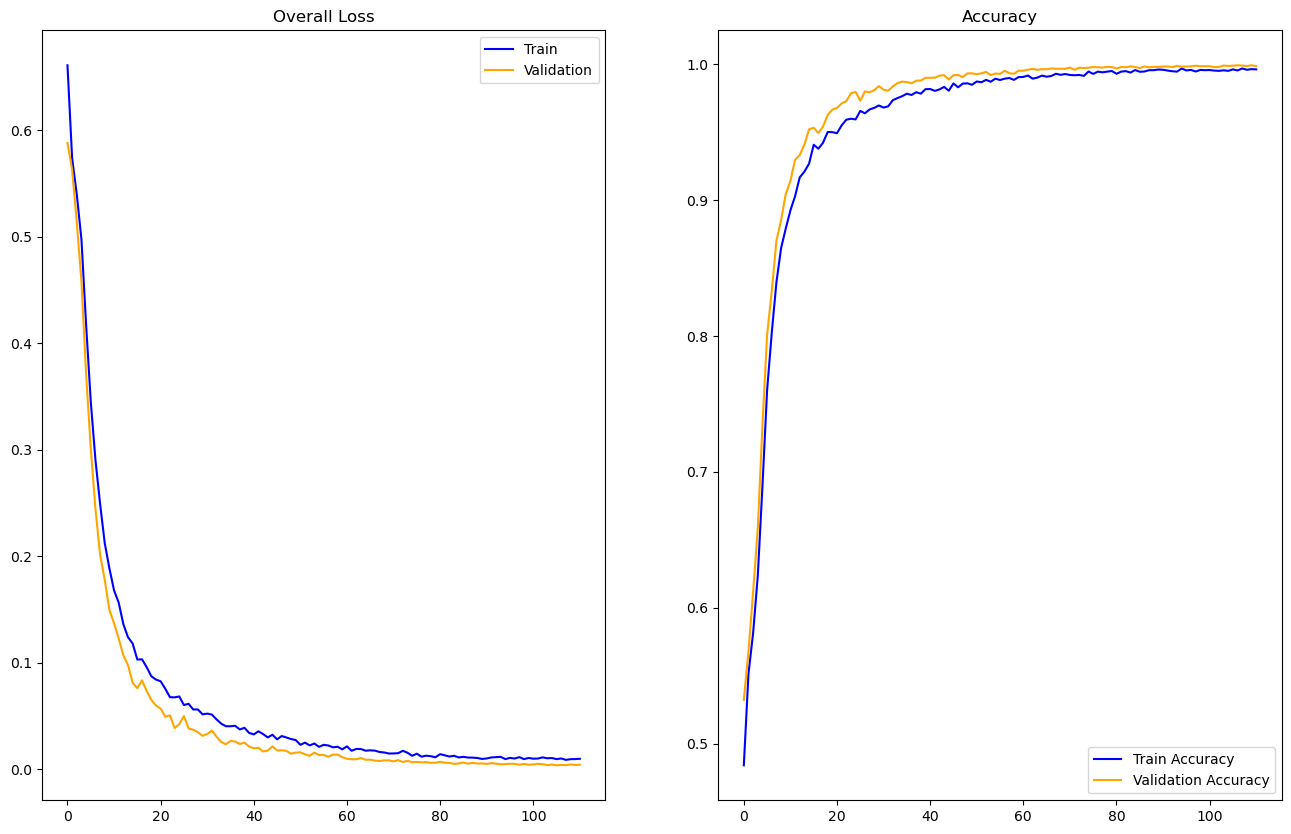

In [43]:
overall, accuracy = train(
    model=model,
    optimizer=optimizer,
    loss=loss_func,
    epochs=epochs,
    dataloader=dataloader,
    val_dataset=alzheimer_dataset,
    scheduler=scheduler,
    plot=True,
    show_progress=True,
    trial=None
)

In [58]:
model.eval()

ConvClassifier(
  (encoder): ConvEncoder(
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
    (block0): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=1, padding=1, dilation=1, ceil_mode=False)
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (max_pool_block0): MaxPoolBlock(
      (max_pool): MaxPool2d(kernel_size=(3, 3), stride=1, padding=1, dilation=1, ceil_mode=True)
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, 

In [44]:
from PIL import Image

In [46]:
test_data_dir = './data/alzheimer/test'
classes = os.listdir(test_data_dir)
class_to_idx = {}
for i in range(len(classes)):
    class_to_idx[classes[i]] = i

total_test_images = 0
for class_name in classes:
    total_test_images += len(os.listdir(f'{test_data_dir}/{class_name}'))

In [52]:
test_images = np.empty((total_test_images, 208, 176), dtype=np.uint8)
test_labels = np.empty(total_test_images, dtype=np.uint8)

In [53]:
image_idx = 0
for class_name in classes:
    for image_name in tqdm(os.listdir(f'{test_data_dir}/{class_name}')):
        image_path = f'{test_data_dir}/{class_name}/{image_name}'
        test_images[image_idx] = np.array(Image.open(image_path)).astype(np.uint8)
        test_labels[image_idx] = class_to_idx[class_name]
        image_idx += 1

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

In [54]:
leftmost_pixel, uppermost_pixel = 16, 16
rightmost_pixel, bottommost_pixel = 159, 191

test_images = test_images[:, uppermost_pixel:bottommost_pixel+1, leftmost_pixel:rightmost_pixel+1]

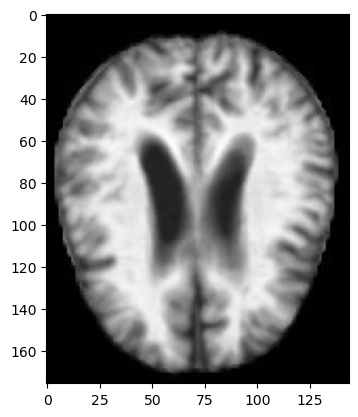

In [56]:
plt.imshow(test_images[test_labels == 1].mean(axis=0), cmap='gray')

In [57]:
test_dataset = AlzheimerDataset(test_images, test_labels)

In [59]:
test_output = model(test_dataset.X.to(model.device))
predictions = torch.argmax(test_output, dim=1).to(model.device)
accuracy = (predictions == test_dataset.y.to(model.device)).sum().item() / predictions.shape[0]

In [60]:
accuracy

0.6090695856137608